<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab7_mbrl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7: Model Based Reinforcement Learning
In this lab, we will star practicing about Gaussian Process and then we will apply it to Model Based RL (MBRL).

## Exercise 1: Intro to Gaussian Processes with GPyTorch

***Objective:*** Build intuition for Gaussian Processes (GPs) by:
- Fitting an **exact GP** to noisy 1D data
- Visualizing **posterior mean + uncertainty**
- Understanding the effects of **noise** and **lengthscale**
- Exploring **extrapolation** (add a linear mean)
- Trying a **sparse GP** with inducing points (optional)

For more information. Check the GP Tutorial: https://docs.gpytorch.ai/en/v1.6.0/examples/01_Exact_GPs/Simple_GP_Regression.html

---

### Data
Use a 1D function with noise:
- f(x) = sin(2πx) + 0.3 * sin(6πx) + 3
- x ∈ [-1.0, 1.0]
- Add Gaussian noise σ_n (try 0.05 and 0.2)

---

## Tasks

### Part A — Exact GP regression (RBF kernel)
1. Implement an **ExactGP** model in GPyTorch:
   - Mean: `ZeroMean`
   - Covariance: `ScaleKernel(RBFKernel)`
   - Likelihood: `GaussianLikelihood`
2. Train by **maximizing log marginal likelihood** (Adam).
3. Plot:
   - Training points
   - Posterior mean
   - 95% confidence band

### Part B — Hyperparameters & data noise
1. Vary the **noise level** in the data (e.g., 0.05 vs 0.2).
2. For each setting, re-train the GP and report learned:
   - `likelihood.noise` (data noise)
   - `kernel.lengthscale`
3. Discuss how these affect smoothness and the width of uncertainty.

### Part C — Extrapolation behavior
1. **Hold out** the rightmost region (e.g., train on x ∈ [-1, 0.5], test on x ∈ (0.5, 1]).
2. Show how the posterior behaves outside the training region.
3. Add a **linear mean** (or `ConstantMean + LinearMean`) and compare extrapolation.

### Part D — (Graduate level) Sparse GP with inducing points
1. Replace Exact GP with **variational inducing-point GP** (SVGP) using `gpytorch.models.ApproximateGP`.
2. Choose M = 32 or 64 inducing points spread across x.
3. Compare posterior to the exact GP.
4. Plot N (number of samples) Vs training time for SVGP and ExactGP

---

## Deliverables
- Code for Parts A–C (Part D for grad students)
- Plots:
  - Mean ± 2 std band with training data
  - Effect of noise and lengthscale
  - Extrapolation comparison (zero vs linear/constant mean)
- Short write-up (≤1 page, as a cell in the notebook):
  - What did increasing noise do to learned hyperparameters and uncertainty?
  - How does the kernel lengthscale affect fit and confidence?
  - Why does the GP behave the way it does when extrapolating? How did the mean function change that?
  - (Grad level) Sparse vs Exact: trade-offs you observed

---

## Hints
- Normalize tensors to `float32` and move to GPU if available.
- Use `model.train(); likelihood.train()` for training, and `.eval()` for evaluation.
- For plotting uncertainty: `lower, upper = pred.confidence_region()`.
- Clip very small noise/lengthscale during early training if it becomes unstable.
- For SVGP, look at: `gpytorch.variational`, `gpytorch.mlls.VariationalELBO`.



In [1]:
x_y=5.0

In [2]:
## Install required libraries
!pip -q install gpytorch torch matplotlib

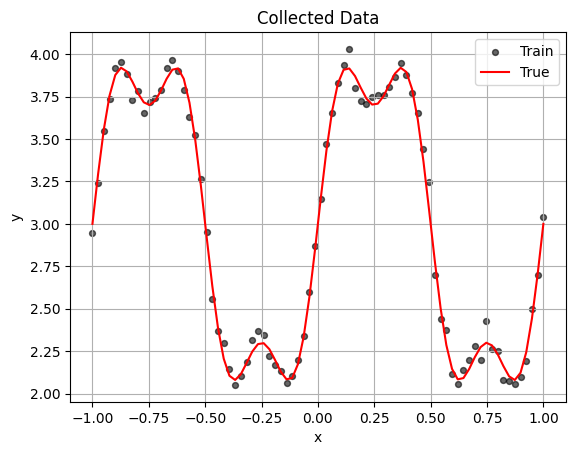

In [3]:
# =======================
# Collecting DATA
# =======================
import torch, math
import gpytorch
import matplotlib.pyplot as plt
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')
torch.manual_seed(0)

# Parameter for data generator
NOISE_STD = 0.05
N = 80

def f(x):
  return torch.sin(2*math.pi*x) + 0.3*torch.sin(6*math.pi*x) + 3


# ---------- Data ----------
def make_data(n=80, noise_std=0.05, train_range=(-1.0, 1.0), holdout_right=False):
    x = torch.linspace(train_range[0], train_range[1], n)
    y_clean = f(x)
    y = y_clean + noise_std*torch.randn_like(y_clean)
    if holdout_right:
        mask = x <= 0.5
        return x[mask].unsqueeze(-1), y[mask], x.unsqueeze(-1), y
    else:
        return x.unsqueeze(-1), y, x.unsqueeze(-1), y

# choose setting
Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=NOISE_STD, holdout_right=False)
Xtr, Ytr, Xgrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device)

# Helper to make tensors plottable
def cpu1d(x):
    return x.detach().cpu().view(-1).numpy()

# Plot data (send copies to CPU)
plt.scatter(cpu1d(Xtr), cpu1d(Ytr), s=18, color='k', alpha=0.6, label='Train')
plt.plot(cpu1d(Xgrid), cpu1d(f(Xgrid)), 'r', label='True')
plt.title('Collected Data')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()


# # Plot data
# plt.scatter(Xtr, Ytr, s=18, color='k', alpha=0.6, label='Train')
# plt.plot(Xgrid, f(Xgrid), 'r', label='True')
# plt.title('Collected Data')
# plt.xlabel('x'); plt.ylabel('y')
# plt.legend(); plt.grid(True); plt.show()

# Part A — Exact GP regression (RBF kernel)

In [4]:
# ---------- Exact GP model ----------
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # TODO (Part A): pick a mean; start with ZeroMean (try Constant/Linear in Part C)
        self.mean_module = gpytorch.means.ZeroMean()
        # TODO (Part A): kernel = ScaleKernel(RBFKernel)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Likelihood + model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(Xtr, Ytr, likelihood).to(device)

iter  200 | loss 0.214 | lengthscale 0.431 | noise 0.0510
iter  400 | loss 0.214 | lengthscale 0.431 | noise 0.0510
iter  600 | loss 0.214 | lengthscale 0.431 | noise 0.0510
iter  800 | loss 0.214 | lengthscale 0.431 | noise 0.0510


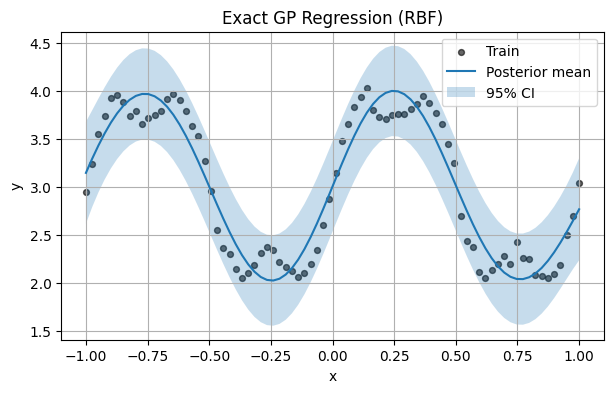

In [6]:
# ---------- Train (maximize log marginal likelihood) ----------
training_iter = 800
model.train(); likelihood.train()
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(Xtr)
    loss = -mll(output, Ytr)
    loss.backward()
    optimizer.step()
    if (i+1) % 200 == 0:
        ls = model.covar_module.base_kernel.lengthscale.item()
        sn = likelihood.noise.item()
        print(f"iter {i+1:4d} | loss {loss.item():.3f} | lengthscale {ls:.3f} | noise {sn:.4f}")

# ---------- Evaluate ----------
model = model.to(device)
likelihood = likelihood.to(device)

#x2 = torch.linspace(-1, 1, N)
x2 = torch.linspace(-1, 1, N, device=device)
model.eval(); likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(x2))
    mean = pred.mean.cpu()
    lower, upper = pred.confidence_region()
    lower, upper = lower.cpu(), upper.cpu()
    
    
x2 = x2.cpu().squeeze()
Ytr_cpu   = Ytr.cpu()
Xtr_cpu   = Xtr.cpu().squeeze()

# ---------- Plot ----------
plt.figure(figsize=(7,4))
plt.scatter(Xtr_cpu, Ytr_cpu, s=18, color='k', alpha=0.6, label='Train')
plt.plot(x2, mean, label='Posterior mean')
plt.fill_between(x2, lower, upper, alpha=0.25, label='95% CI')
plt.title('Exact GP Regression (RBF)')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()


# Part B — Hyperparameters & data noise

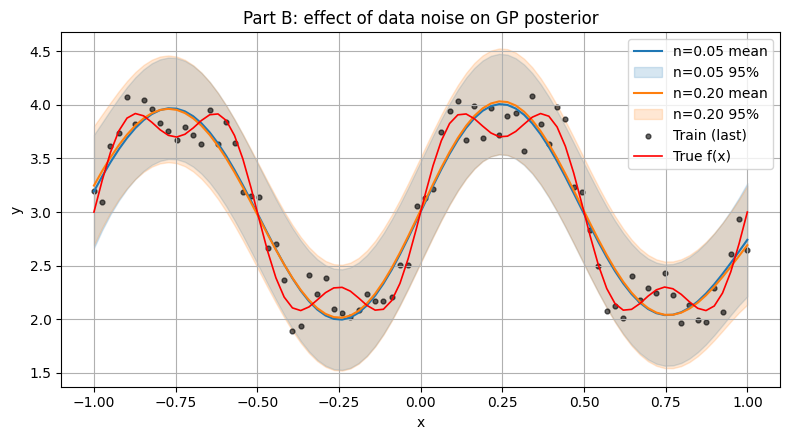

data noise std=0.050 -> learned lengthscale=0.414, likelihood.noise(var)=0.0509 (std≈0.226)
data noise std=0.200 -> learned lengthscale=0.413, likelihood.noise(var)=0.0564 (std≈0.238)


In [7]:
# ---- helper: exact GP with RBF ----
class ExactRBF(gpytorch.models.ExactGP):
    def __init__(self, X, y, lik):
        super().__init__(X, y, lik)
        self.mean_module  = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(
            self.mean_module(x), self.covar_module(x)
        )

def train_exact(X, y, iters=600, lr=0.05):
    lik = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactRBF(X, y, lik).to(device)
    model.train()
    lik.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(lik, model)
    for _ in range(iters):
        opt.zero_grad(); out = model(X)
        loss = -mll(out, y); loss.backward(); opt.step()
    return model, lik

def np1d(t): return t.detach().flatten().cpu().numpy()

# ---- run two noise settings (e.g., 0.05 vs 0.20) ----
noise_levels = [0.05, 0.20]
results = []

plt.figure(figsize=(8,4.5))
colors = ['C0','C1']

for nl, c in zip(noise_levels, colors):
    # new dataset with different noise
    Xtr, Ytr, Xgrid, _ = make_data(n=N, noise_std=nl, holdout_right=False)
    Xtr, Ytr, Xgrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device)

    # train fresh model
    model, lik = train_exact(Xtr, Ytr, iters=600, lr=0.05)

    # read hyperparams
    lengthscale = model.covar_module.base_kernel.lengthscale.item()
    noise_var   = lik.noise.item()  # this is variance, not std
    results.append((nl, lengthscale, noise_var))

    # predict on dense grid
    model.eval(); lik.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        post = lik(model(Xgrid))
        mean = post.mean
        lo, hi = post.confidence_region()

    # plot posterior for this noise level
    plt.plot(np1d(Xgrid), np1d(mean), c=c, label=f'n={nl:.2f} mean')
    plt.fill_between(np1d(Xgrid), np1d(lo), np1d(hi), color=c, alpha=0.18, label=f'n={nl:.2f} 95%')

# training points from the last run (just for context)
plt.scatter(np1d(Xtr), np1d(Ytr), s=12, color='k', alpha=0.6, label='Train (last)')
plt.plot(np1d(Xgrid), np1d(f(Xgrid)), 'r', lw=1.2, label='True f(x)')
plt.title('Part B: effect of data noise on GP posterior')
plt.xlabel('x'); plt.ylabel('y'); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# print the learned hyperparameters
for nl, ls, nv in results:
    print(f"data noise std={nl:.3f} -> learned lengthscale={ls:.3f}, likelihood.noise(var)={nv:.4f} (std≈{nv**0.5:.3f})")


- Higher data noise, larger learned likelihood.noise and wider 95% CI bands.

- The RBF lengthscale usually increases with higher noise (model smooths more to avoid fitting noise). With low noise it can shrink to fit finer wiggles.

- The posterior mean changes little inside dense data, but uncertainty grows where the function is less constrained (between points and especially outside the range).

# Part C — Extrapolation behavior

ZeroMean  -> lengthscale=0.405, noise(var)=0.0499
Const+Lin -> lengthscale=0.135, noise(var)=0.0023


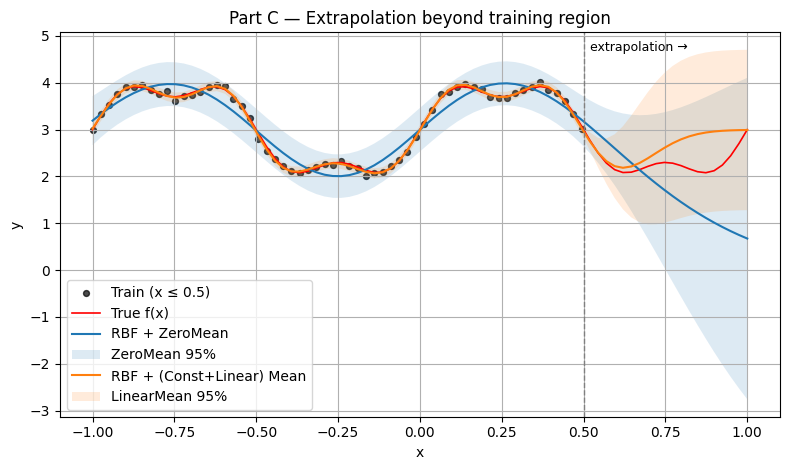

In [4]:
# ========= Part C: Extrapolation behavior =========
import gpytorch, torch, matplotlib.pyplot as plt

def np1d(t):  # plotting helper (no side effects on your CUDA tensors)
    return t.detach().flatten().cpu().numpy()

# 1) Hold out rightmost region: train on x ∈ [-1, 0.5], test/plot on [-1, 1]
Xtr, Ytr, Xgrid, _ = make_data(n=N, noise_std=NOISE_STD, holdout_right=True)
Xtr, Ytr, Xgrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device)

# ----- GP model that lets us swap mean modules -----
class ExactRBF(gpytorch.models.ExactGP):
    def __init__(self, X, y, likelihood, mean_module):
        super().__init__(X, y, likelihood)
        self.mean_module  = mean_module
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp(X, y, mean_module, iters=600, lr=0.05):
    lik = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactRBF(X, y, lik, mean_module).to(device)
    model.train(); lik.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(lik, model)
    for _ in range(iters):
        opt.zero_grad()
        out  = model(X)
        loss = -mll(out, y)
        loss.backward()
        opt.step()
    return model, lik

def predict(model, lik, X):
    model.eval(); lik.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        post = lik(model(X))
        mean = post.mean
        lo, hi = post.confidence_region()
    return mean, lo, hi


# ---- sum of ConstantMean and LinearMean ----
class ConstPlusLinearMean(gpytorch.means.Mean):
    def __init__(self, input_size=1):
        super().__init__()
        self.const  = gpytorch.means.ConstantMean()
        self.linear = gpytorch.means.LinearMean(input_size)

    def forward(self, x):
        return self.const(x) + self.linear(x)


# 2) Train baseline (ZeroMean) and 3) Linear mean (Const + Linear)
# baseline
m0, lk0 = fit_gp(Xtr, Ytr, gpytorch.means.ZeroMean())

# linear-mean GP
m1, lk1 = fit_gp(Xtr, Ytr, ConstPlusLinearMean(input_size=Xtr.size(-1)))

#m1, lk1 = fit_gp(Xtr, Ytr, gpytorch.means.ConstantMean() + gpytorch.means.LinearMean(input_size=1))

m0_mean, m0_lo, m0_hi = predict(m0, lk0, Xgrid)
m1_mean, m1_lo, m1_hi = predict(m1, lk1, Xgrid)

# (optional) print learned hypers
print("ZeroMean  -> lengthscale=%.3f, noise(var)=%.4f" %
      (m0.covar_module.base_kernel.lengthscale.item(), lk0.noise.item()))
print("Const+Lin -> lengthscale=%.3f, noise(var)=%.4f" %
      (m1.covar_module.base_kernel.lengthscale.item(), lk1.noise.item()))

# ---------- Plot ----------
plt.figure(figsize=(8,4.8))
# training points (only x ≤ 0.5)
plt.scatter(np1d(Xtr), np1d(Ytr), s=18, color='k', alpha=0.7, label='Train (x ≤ 0.5)')

# true function
plt.plot(np1d(Xgrid), np1d(f(Xgrid)), 'r', lw=1.2, label='True f(x)')

# ZeroMean posterior
plt.plot(np1d(Xgrid), np1d(m0_mean), label='RBF + ZeroMean')
plt.fill_between(np1d(Xgrid), np1d(m0_lo), np1d(m0_hi), alpha=0.15, label='ZeroMean 95%')

# Linear-mean posterior
plt.plot(np1d(Xgrid), np1d(m1_mean), label='RBF + (Const+Linear) Mean')
plt.fill_between(np1d(Xgrid), np1d(m1_lo), np1d(m1_hi), alpha=0.15, label='LinearMean 95%')

# highlight extrapolation region
plt.axvline(0.5, ls='--', c='gray', lw=1)
plt.text(0.52, plt.ylim()[1]*0.92, 'extrapolation →', fontsize=9)

plt.title('Part C — Extrapolation beyond training region')
plt.xlabel('x'); plt.ylabel('y'); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


# Part D — (Graduate level) Sparse GP with inducing points

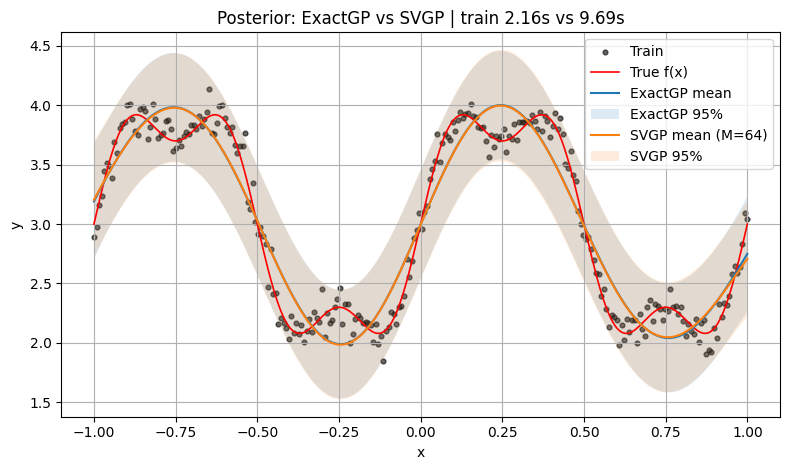

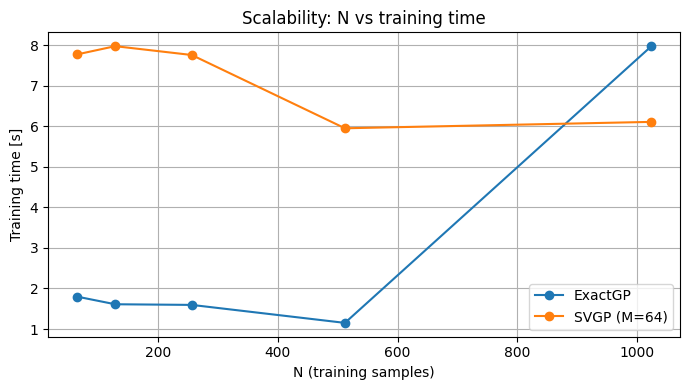

In [5]:
# ===== Part D: Sparse GP with inducing points (GPyTorch) =====
import time, math, torch, gpytorch, matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

# ----- toy function & data -----
def f(x):  # 1D -> 1D
    return torch.sin(2*math.pi*x) + 0.3*torch.sin(6*math.pi*x) + 3

def make_data(n=256, noise_std=0.1, train_range=(-1.0, 1.0)):
    x = torch.linspace(train_range[0], train_range[1], n)
    y = f(x) + noise_std*torch.randn_like(x)
    return x.unsqueeze(-1), y

def np1d(t): return t.detach().flatten().cpu().numpy()

# ===== Exact GP (baseline) =====
class ExactRBF(gpytorch.models.ExactGP):
    def __init__(self, X, y, likelihood):
        super().__init__(X, y, likelihood)
        self.mean_module  = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    def forward(self, x):
        m = self.mean_module(x)
        K = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(m, K)

def fit_exact(X, y, iters=600, lr=0.05):
    lik = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactRBF(X, y, lik).to(device)
    model.train(); lik.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(lik, model)
    t0 = time.perf_counter()
    for _ in range(iters):
        opt.zero_grad()
        out  = model(X)
        loss = -mll(out, y)
        loss.backward()
        opt.step()
    t_train = time.perf_counter() - t0
    return model, lik, t_train

# ===== SVGP (variational inducing-point GP) =====
class SVGP_RBF(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        M = inducing_points.size(0)
        q = gpytorch.variational.CholeskyVariationalDistribution(M)
        strat = gpytorch.variational.VariationalStrategy(
            self, inducing_points, q, learn_inducing_locations=True
        )
        super().__init__(strat)
        self.mean_module  = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    def forward(self, x):
        m = self.mean_module(x)
        K = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(m, K)

def fit_svgp(X, y, M=64, iters=1000, lr=0.03, batch_size=None):
    # induce points across input range
    x_min, x_max = X.min().item(), X.max().item()
    Z = torch.linspace(x_min, x_max, M, device=device).unsqueeze(-1)

    model = SVGP_RBF(Z).to(device)
    lik   = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model.train(); lik.train()

    params = [{'params': model.parameters()}, {'params': lik.parameters()}]
    opt = torch.optim.Adam(params, lr=lr)

    N = X.size(0)
    elbo = gpytorch.mlls.VariationalELBO(lik, model, num_data=N)

    # optional minibatching
    if batch_size is None or batch_size >= N:
        t0 = time.perf_counter()
        for _ in range(iters):
            opt.zero_grad()
            out  = model(X)
            loss = -elbo(out, y)
            loss.backward()
            opt.step()
        t_train = time.perf_counter() - t0
    else:
        # simple shuffling minibatch loop
        t0 = time.perf_counter()
        for _ in range(iters):
            idx = torch.randperm(N, device=device)
            for i in range(0, N, batch_size):
                sl = idx[i:i+batch_size]
                opt.zero_grad()
                out  = model(X[sl])
                loss = -elbo(out, y[sl])
                loss.backward()
                opt.step()
        t_train = time.perf_counter() - t0

    return model, lik, t_train

# =================== Posterior comparison ===================
N = 256
noise_std = 0.10
Xtr, Ytr = make_data(n=N, noise_std=noise_std)
Xtr, Ytr = Xtr.to(device), Ytr.to(device)

# grid for plotting
Xgrid = torch.linspace(-1.0, 1.0, 400, device=device).unsqueeze(-1)

# Train ExactGP
exact_model, exact_lik, t_exact = fit_exact(Xtr, Ytr, iters=600)

# Train SVGP (choose M = 32 or 64)
M = 64
svgp_model, svgp_lik, t_svgp = fit_svgp(Xtr, Ytr, M=M, iters=1000, lr=0.03)

# Predict
exact_model.eval(); exact_lik.eval()
svgp_model.eval();  svgp_lik.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pE = exact_lik(exact_model(Xgrid))
    pS = svgp_lik(svgp_model(Xgrid))

E_mean, (E_lo, E_hi) = pE.mean, pE.confidence_region()
S_mean, (S_lo, S_hi) = pS.mean, pS.confidence_region()

# Plot comparison
plt.figure(figsize=(8,4.8))
plt.scatter(np1d(Xtr), np1d(Ytr), s=12, c='k', alpha=0.6, label='Train')
plt.plot(np1d(Xgrid), np1d(f(Xgrid)), 'r', lw=1.2, label='True f(x)')

plt.plot(np1d(Xgrid), np1d(E_mean), label='ExactGP mean')
plt.fill_between(np1d(Xgrid), np1d(E_lo), np1d(E_hi), alpha=0.15, label='ExactGP 95%')

plt.plot(np1d(Xgrid), np1d(S_mean), label=f'SVGP mean (M={M})')
plt.fill_between(np1d(Xgrid), np1d(S_lo), np1d(S_hi), alpha=0.15, label='SVGP 95%')

plt.title(f'Posterior: ExactGP vs SVGP | train {t_exact:.2f}s vs {t_svgp:.2f}s')
plt.xlabel('x'); plt.ylabel('y'); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# =================== N vs training time ===================
N_list = [64, 128, 256, 512, 1024]  # increase if your GPU/RAM allows
t_exact_list, t_svgp_list = [], []
M = 64

for Nn in N_list:
    Xn, Yn = make_data(n=Nn, noise_std=noise_std)
    Xn, Yn = Xn.to(device), Yn.to(device)

    # shorter iters for larger N to keep this quick
    it_exact = 500 if Nn <= 256 else 300
    it_svgp  = 800 if Nn <= 256 else 500

    _, _, tE = fit_exact(Xn, Yn, iters=it_exact)
    _, _, tS = fit_svgp (Xn, Yn, M=M, iters=it_svgp)

    t_exact_list.append(tE)
    t_svgp_list.append(tS)

plt.figure(figsize=(7,4))
plt.plot(N_list, t_exact_list, marker='o', label='ExactGP')
plt.plot(N_list, t_svgp_list,  marker='o', label=f'SVGP (M={M})')
plt.xlabel('N (training samples)'); plt.ylabel('Training time [s]')
plt.title('Scalability: N vs training time')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


## Exercise 2 (Optional, except PhD students): Model-Based Reinforcement Learning with Gaussian Process + MPC
***Goal:***
Learn the core ideas of **Model-Based Reinforcement Learning (MBRL)** by:
- Learning a **dynamics model** with a Gaussian Process (GP)
- Using **Model Predictive Control (MPC)** to plan actions
- Comparing against random or fixed policies

We’ll use a simplified version of **GP-MPC** (similar in spirit to PILCO or PETS) on the *MountainCarContinuous-v0* task.

---

## 1 Background
The system dynamics are unknown.  
We collect transitions
$(x_t, u_t, r_t, x_{t+1})$
and learn a GP model of the change in state:
$\Delta x = f(x_t, u_t) + \varepsilon$
Then, given a current state, we **simulate** future trajectories using the GP mean prediction and pick an action sequence that maximizes the expected reward (or minimizes cost) over a short horizon — the **MPC** loop.

---

## 2 Steps

### Part A — Collect data with a random policy
1. Run `N = 1000` random actions.
2. Store transitions \((x_t, u_t, x_{t+1})\).
3. Compute state differences:  
   `dx = x_next - x`.

### Part B — Train a Gaussian Process model
1. Fit a GP for each state dimension (here 2: position and velocity).  
   Inputs = `[x_t, u_t]`  
   Outputs = `dx_t`
2. Use **GPyTorch** or **sklearn.gaussian_process**.
3. Plot model predictions vs. ground truth for a few samples.

### Part C — Implement a simple MPC controller
1. At each step:
   - Start from current state \(x_t\).
   - Sample \(K\) random control sequences of horizon \(H\).
   - For each sequence, **simulate forward** using GP predictions.
   - Compute cumulative reward (from MountainCarContinuous env).
   - Execute the *first action* of the best sequence.
2. Repeat until termination or max steps.

### Part D — Evaluate and visualize
1. Plot the car’s trajectory (position vs. time).
2. Compare with random policy performance.
3. Discuss:  
   - How does the GP model’s accuracy affect control?  
   - How many random samples or planning horizon are needed?

---

## Deliverables
- Code for data collection, GP training, and MPC loop.
- Plots:
  - GP predictions vs. true next states.
  - Car’s position vs. time during control.
- Short discussion (≈½ page):
  - How did planning horizon affect performance?
  - How does GP uncertainty limit long-term planning?

---

## Optional extensions
- Add GP uncertainty penalty in cost function.
- Try a learned NN model instead of GP.
- Use warm-start data from a heuristic controller.
- Compare Exact GP vs. Sparse GP (SVGP).

---

## Hints
- Normalize inputs and outputs before GP training.
- Use a small horizon (H≈15–20) for efficiency.
- Reward function from environment:
  ```python
  reward = 100 * (abs(x) >= 0.45) - 0.1 * u**2

# Part A

In [1]:
# Part A — Collect data with a random policy (Gymnasium)
import numpy as np
import gymnasium as gym

def collect_random_data(env_name="MountainCarContinuous-v0", N=1000, seed=0, save_path=None):
    """
    Returns:
      X      : (N, S)    states x_t
      U      : (N, A)    actions u_t
      R      : (N,)      rewards r_t
      X_next : (N, S)    next states x_{t+1}
      dX     : (N, S)    state differences x_{t+1} - x_t
    """
    rng = np.random.default_rng(seed)
    env = gym.make(env_name)
    obs, _ = env.reset(seed=seed)

    S = env.observation_space.shape[0]
    A = env.action_space.shape[0]
    low, high = env.action_space.low, env.action_space.high

    X      = np.zeros((N, S), dtype=np.float32)
    U      = np.zeros((N, A), dtype=np.float32)
    R      = np.zeros((N,),   dtype=np.float32)
    X_next = np.zeros((N, S), dtype=np.float32)

    i = 0
    while i < N:
        # sample a random action uniformly over the valid bounds
        u = rng.uniform(low=low, high=high, size=A).astype(np.float32)

        obs_next, r, terminated, truncated, _ = env.step(u)

        X[i]      = obs
        U[i]      = u
        R[i]      = r
        X_next[i] = obs_next

        obs = obs_next
        done = terminated or truncated
        if done:
            obs, _ = env.reset()

        i += 1

    env.close()
    dX = X_next - X

    if save_path is not None:
        np.savez_compressed(save_path, X=X, U=U, R=R, X_next=X_next, dX=dX)
        print(f"Saved dataset to {save_path}")

    return X, U, R, X_next, dX

# Example run
if __name__ == "__main__":
    X, U, R, X_next, dX = collect_random_data(N=1000, seed=42, save_path="gp_mpc_random_data.npz")
    print("Shapes -> X:", X.shape, "U:", U.shape, "R:", R.shape, "X_next:", X_next.shape, "dX:", dX.shape)
    # quick sanity check: mean/var of dX
    print("dX mean:", dX.mean(axis=0), " | dX std:", dX.std(axis=0))


Saved dataset to gp_mpc_random_data.npz
Shapes -> X: (1000, 2) U: (1000, 1) R: (1000,) X_next: (1000, 2) dX: (1000, 2)
dX mean: [-3.2732653e-04  2.8187775e-05]  | dX std: [0.014118   0.00145227]


# Part B

Loaded dataset from gp_mpc_random_data.npz  shapes -> X(1000, 2), U(1000, 1), dX(1000, 2)

=== Training GP for Δx[0] ===
iter  100  nll=-1.685
iter  200  nll=-3.401
iter  300  nll=-3.583
iter  400  nll=-3.618
iter  500  nll=-3.500
iter  600  nll=-3.637
iter  700  nll=-3.636
iter  800  nll=-3.644

=== Training GP for Δx[1] ===
iter  100  nll=-1.648
iter  200  nll=-3.326
iter  300  nll=-3.518
iter  400  nll=-3.556
iter  500  nll=-3.572
iter  600  nll=-3.582
iter  700  nll=-3.588
iter  800  nll=-3.593

RMSE per state-dimension on Δx (units of state): [8.6095570e-06 1.5177967e-06]


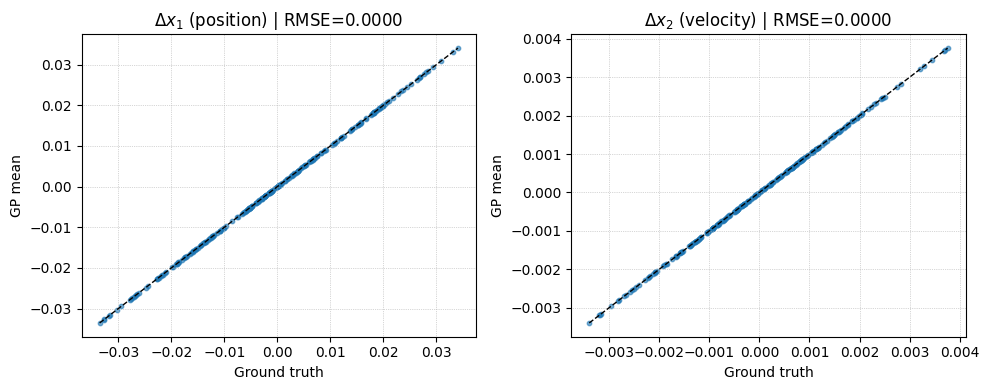

In [2]:
# Part B — Train a Gaussian Process model with GPyTorch
import os, numpy as np, torch, gpytorch, matplotlib.pyplot as plt

# ---------- A) Load (or create) data ----------
def load_or_make_data(path="gp_mpc_random_data.npz", N=1000, seed=42):
    try:
        D = np.load(path)
        X, U, dX = D["X"], D["U"], D["dX"]
        print(f"Loaded dataset from {path}  shapes -> X{X.shape}, U{U.shape}, dX{dX.shape}")
    except FileNotFoundError:
        import gymnasium as gym
        rng = np.random.default_rng(seed)
        env = gym.make("MountainCarContinuous-v0")
        obs, _ = env.reset(seed=seed)
        S, A = env.observation_space.shape[0], env.action_space.shape[0]
        low, high = env.action_space.low, env.action_space.high
        X = np.zeros((N, S), np.float32); U = np.zeros((N, A), np.float32); Xn = np.zeros_like(X)
        i = 0
        while i < N:
            u = rng.uniform(low=low, high=high, size=A).astype(np.float32)
            obs_next, _, term, trunc, _ = env.step(u)
            X[i] = obs; U[i] = u; Xn[i] = obs_next
            obs = obs_next
            if term or trunc: obs, _ = env.reset()
            i += 1
        env.close()
        dX = Xn - X
        np.savez_compressed(path, X=X, U=U, R=np.zeros(N), X_next=Xn, dX=dX)
        print(f"Generated and saved dataset to {path}")
    return X, U, dX

X, U, dX = load_or_make_data()
Z = np.concatenate([X, U], axis=1).astype(np.float32)   # inputs [pos, vel, action], shape (N,3)
Y = dX.astype(np.float32)                                # targets Δx, shape (N,2)

# ---------- B) Torch tensors & train/test split ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
N = Z.shape[0]
perm = torch.randperm(N)
split = int(0.75 * N)
idx_tr, idx_te = perm[:split], perm[split:]

Zt = torch.from_numpy(Z).to(device)
Yt = torch.from_numpy(Y).to(device)

Z_tr, Z_te = Zt[idx_tr], Zt[idx_te]
Y_tr, Y_te = Yt[idx_tr], Yt[idx_te]

# ---------- C) Standardize (affine normalize) ----------
z_mean, z_std = Z_tr.mean(0), Z_tr.std(0).clamp_min(1e-6)
y_mean, y_std = Y_tr.mean(0), Y_tr.std(0).clamp_min(1e-6)

def z_norm(z): return (z - z_mean) / z_std
def y_norm(y): return (y - y_mean) / y_std
def y_unnorm(yn): return yn * y_std + y_mean

Z_tr_n, Z_te_n = z_norm(Z_tr), z_norm(Z_te)
Y_tr_n = y_norm(Y_tr)

# ---------- D) GP model (ExactGP) ----------
class AffineMean(gpytorch.means.Mean):
    """Linear + bias mean: m(z) = w^T z + b  (avoids ConstantMean()+LinearMean issue)"""
    def __init__(self, input_size):
        super().__init__()
        self.register_parameter(name="weights", parameter=torch.nn.Parameter(torch.zeros(input_size)))
        self.register_parameter(name="bias", parameter=torch.nn.Parameter(torch.zeros(1)))
    def forward(self, x):
        return x.matmul(self.weights) + self.bias

class SingleOutputExactGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = AffineMean(train_x.shape[-1])
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[-1])
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp(train_x, train_y, iters=800, lr=0.05):
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = SingleOutputExactGP(train_x, train_y, likelihood).to(device)
    model.train(); likelihood.train()
    opt = torch.optim.Adam([{'params': model.parameters()}], lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for i in range(iters):
        opt.zero_grad(set_to_none=True)
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        opt.step()
        if (i+1) % 100 == 0:
            print(f"iter {i+1:4d}  nll={loss.item():.3f}")
    return model, likelihood

# Train two independent GPs: one for Δpos, one for Δvel
gp_models = []
for j in range(Y.shape[1]):
    print(f"\n=== Training GP for Δx[{j}] ===")
    yj = Y_tr_n[:, j]
    m, lk = fit_gp(Z_tr_n, yj, iters=800, lr=0.05)
    gp_models.append((m.eval(), lk.eval()))

# ---------- E) Predict on test and compute RMSE ----------
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds_s = []
    for (m, lk) in gp_models:
        dist = m(Z_te_n)
        mean = lk(dist).mean  # mean of predictive (same as dist.mean for GaussianLikelihood)
        preds_s.append(mean)
    Y_pred_n = torch.stack(preds_s, dim=1)
    Y_pred = y_unnorm(Y_pred_n)

rmse = torch.sqrt(torch.mean((Y_pred - Y_te)**2, dim=0))
print(f"\nRMSE per state-dimension on Δx (units of state): {rmse.cpu().numpy()}")

# ---------- F) Parity plots ----------
Y_te_np = Y_te.detach().cpu().numpy()
Y_pr_np = Y_pred.detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
labels = [r"$\Delta x_1$ (position)", r"$\Delta x_2$ (velocity)"]
for j, ax in enumerate(axes):
    ax.scatter(Y_te_np[:, j], Y_pr_np[:, j], s=10, alpha=0.6)
    lo = float(min(Y_te_np[:, j].min(), Y_pr_np[:, j].min()))
    hi = float(max(Y_te_np[:, j].max(), Y_pr_np[:, j].max()))
    ax.plot([lo, hi], [lo, hi], 'k--', lw=1)
    ax.set_xlabel("Ground truth")
    ax.set_ylabel("GP mean")
    ax.set_title(f"{labels[j]} | RMSE={rmse[j].item():.4f}")
    ax.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()

# ---------- G) Convenience: callable GP dynamics (mean prediction) ----------
def gp_dynamics_predict(x, u):
    """
    x: (...,2) state [pos, vel]
    u: (...,1) action
    returns mean Δx (...,2) as torch tensor on current device
    """
    z = torch.cat([torch.as_tensor(x, dtype=torch.float32, device=device).reshape(-1, 2),
                   torch.as_tensor(u, dtype=torch.float32, device=device).reshape(-1, 1)], dim=1)
    z_n = (z - z_mean) / z_std
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        outs = []
        for (m, lk) in gp_models:
            outs.append(lk(m(z_n)).mean)
        dx_n = torch.stack(outs, dim=1)
    return dx_n * y_std + y_mean  # unnormalize


# Part C

In [ ]:
# ===== Window 1: Setup + gp_dynamics_predict sanity checks =====
import torch, numpy as np

# 1) Device: prefer CUDA, but fall back safely if not available
device = torch.device("cuda")
print("Device:", device)

# 2) MountainCarContinuous goal (termination position)
GOAL_POS = 0.45

# 3) Make sure Part B was run and gp_dynamics_predict exists
assert 'gp_dynamics_predict' in globals(), "Run your Part B cell first so gp_dynamics_predict is defined."

# 4) Batch/device/dtype check for gp_dynamics_predict
K = 2048  # batch size 
x = torch.zeros(K, 2, device=device, dtype=torch.float32)   # [pos, vel]
u = torch.zeros(K, 1, device=device, dtype=torch.float32)   # action

with torch.no_grad():
    dx = gp_dynamics_predict(x, u)

# 5) Validate shape, device, dtype
assert isinstance(dx, torch.Tensor), "gp_dynamics_predict must return a torch.Tensor"
assert dx.shape == (K, 2), f"Expected (K,2) = ({K},2) but got {tuple(dx.shape)}"
assert dx.device.type == device.type, f"gp_dynamics_predict returned on {dx.device}, expected {device}"
assert dx.dtype == torch.float32, f"gp_dynamics_predict returned {dx.dtype}, expected torch.float32"

print("[check] gp_dynamics_predict passes (shape/device/dtype). Proceed to Window 2.")


Device: cuda
[check] gp_dynamics_predict passes (shape/device/dtype). Proceed to Window 2.


In [4]:
# ===== Window 2: MPPI (no rendering) =====
import torch

# Uses `device` and `GOAL_POS` from Window 1
assert 'device' in globals() and 'GOAL_POS' in globals()
assert 'gp_dynamics_predict' in globals(), "gp_dynamics_predict must be defined (from Part B)."

def mc_reward_vec(x_next, u):
    # x_next: (K,2)  u: (K,1)
    r = (x_next[:, 0] >= GOAL_POS).float() * 100.0   # terminal bonus at goal
    r = r - 0.1 * (u[:, 0] ** 2)                     # action penalty
    r = r + 3.0 * x_next[:, 0]                       # position shaping
    r = r + 1.5 * torch.clamp(x_next[:, 1], min=0.0) # small bonus for rightward speed
    return r

class MPPI:
    """
    Fully-batched MPPI with AR(1) time-correlated noise.
    Keep everything float32 on `device`. Assumes gp_dynamics_predict(x,u) -> Δx (K,2).
    """
    def __init__(self, act_low, act_high, H=32, K=1536, sigma=0.45, lam=1.0, seed=0, rho=0.8):
        self.H, self.K = int(H), int(K)
        self.sigma, self.lam, self.rho = float(sigma), float(lam), float(rho)
        self.act_low  = torch.as_tensor([[act_low]],  device=device, dtype=torch.float32)
        self.act_high = torch.as_tensor([[act_high]], device=device, dtype=torch.float32)
        self.U_bar = torch.zeros(self.H, 1, device=device, dtype=torch.float32)
        g = torch.Generator(device=device); g.manual_seed(int(seed))
        self.rng = g

    @torch.no_grad()
    def _sample_noise(self):
        K, H = self.K, self.H
        eps = torch.zeros(K, H, 1, device=device, dtype=torch.float32)
        z   = torch.randn(K, H, 1, device=device, generator=self.rng, dtype=torch.float32)
        eps[:, 0, :] = self.sigma * z[:, 0, :]
        if H > 1:
            step_std = self.sigma * (1.0 - self.rho**2) ** 0.5
            for t in range(1, H):
                eps[:, t, :] = self.rho * eps[:, t-1, :] + step_std * z[:, t, :]
        return eps  # (K,H,1)

    @torch.no_grad()
    def plan(self, x0):
        # x0: (2,) array-like
        x0 = torch.as_tensor(x0, dtype=torch.float32, device=device).reshape(2)
        U  = torch.clamp(self.U_bar.unsqueeze(0) + self._sample_noise(), self.act_low, self.act_high)  # (K,H,1)

        x     = x0.expand(self.K, -1).clone()                          # (K,2)
        done  = torch.zeros(self.K, dtype=torch.bool, device=device)
        costs = torch.zeros(self.K, device=device, dtype=torch.float32)

        for t in range(self.H):
            u_t = U[:, t, :]                                           # (K,1)
            dx  = gp_dynamics_predict(x, u_t)                          # (K,2)
            x   = x + dx
            r   = mc_reward_vec(x, u_t)                                # (K,)
            costs -= torch.where(done, torch.zeros_like(r), r)
            done |= (x[:, 0] >= GOAL_POS)

        # MPPI importance weights
        cmin = costs.min()
        w = torch.exp(-(costs - cmin) / self.lam)                      # (K,)
        Z = torch.clamp(w.sum(), min=1e-12)

        # Update mean sequence and warm-start (shift)
        self.U_bar = (w.view(self.K, 1, 1) * U).sum(dim=0) / Z          # (H,1)
        self.U_bar = torch.clamp(self.U_bar, self.act_low, self.act_high)
        a0 = self.U_bar[0].clone()
        self.U_bar = torch.roll(self.U_bar, shifts=-1, dims=0); self.U_bar[-1] = 0.0
        return a0


In [28]:
# ===== Window 3: Tuned MPPI with ORACLE dynamics to validate the planner =====
import time, numpy as np, torch, gymnasium as gym

assert 'MPPI' in globals(), "Run Window 2 so MPPI is defined."
assert 'device' in globals() and 'GOAL_POS' in globals()

# --- True MountainCarContinuous dynamics: returns Δx (batch) ---
def true_dynamics_dx(x, u):
    # x: (K,2) [pos, vel], u: (K,1) in [-1,1]
    pos, vel = x[:, 0], x[:, 1]
    force = torch.clamp(u[:, 0], -1.0, 1.0)
    vel_next = vel + force * 0.0015 - 0.0025 * torch.cos(3.0 * pos)
    pos_next = pos + vel_next
    return torch.stack([pos_next - pos, vel_next - vel], dim=1)

# --- Swap to oracle dynamics just for this test ---
_gp_backup = gp_dynamics_predict
gp_dynamics_predict = true_dynamics_dx

def run_oracle_tuned(H=100, K=100, sigma=0.6, lam=50.0, rho=0.95, seed=7, max_steps=5500):
    env = gym.make("MountainCarContinuous-v0", render_mode="human")  # headless
    obs, _ = env.reset(seed=seed)
    low, high = env.action_space.low[0], env.action_space.high[0]

    mppi = MPPI(low, high, H=H, K=K, sigma=sigma, lam=lam, seed=seed, rho=rho)

    # Prime the sequence with a decisive left shove so MPPI can refine the swing
    warm_left = min(10, H)  # up to 60 steps of reverse
    mppi.U_bar[:warm_left] = -0.1

    total_return, success_step, plan_times = 0.0, None, []
    for t in range(max_steps):
        t0 = time.perf_counter()
        a = mppi.plan(obs).detach().cpu().numpy()
        if torch.cuda.is_available(): torch.cuda.synchronize()
        plan_times.append(time.perf_counter() - t0)

        obs, r, terminated, truncated, _ = env.step(a)
        total_return += r
        if obs[0] >= GOAL_POS and success_step is None:
            success_step = t + 1
        if terminated or truncated:
            break
    env.close()
    return {
        "return": float(total_return),
        "success": bool(success_step is not None),
        "success_step": int(success_step) if success_step is not None else None,
        "plan_ms_median": float(np.median(plan_times) * 1000.0),
        "H": H, "K": K, "sigma": sigma, "lam": lam, "rho": rho
    }

oracle_stats = run_oracle_tuned()
print("Oracle (tuned) :", oracle_stats)

# --- Restore your GP predictor after the oracle test ---
gp_dynamics_predict = _gp_backup


Oracle (tuned) : {'return': 93.83325497717713, 'success': True, 'success_step': 99, 'plan_ms_median': 51.606399996671826, 'H': 100, 'K': 100, 'sigma': 0.6, 'lam': 50.0, 'rho': 0.95}


# Part D

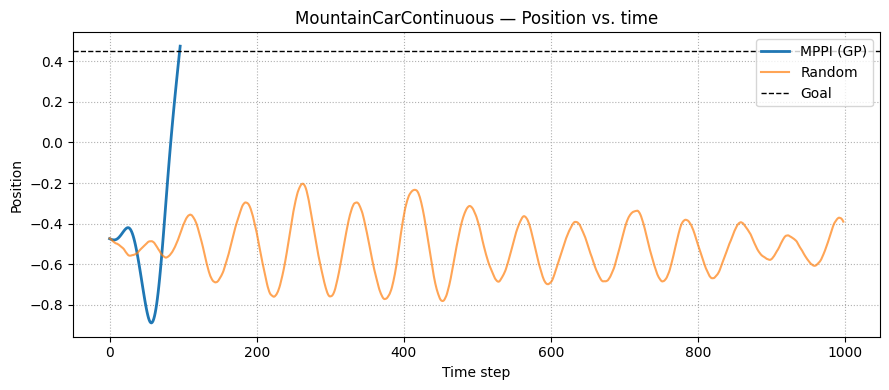

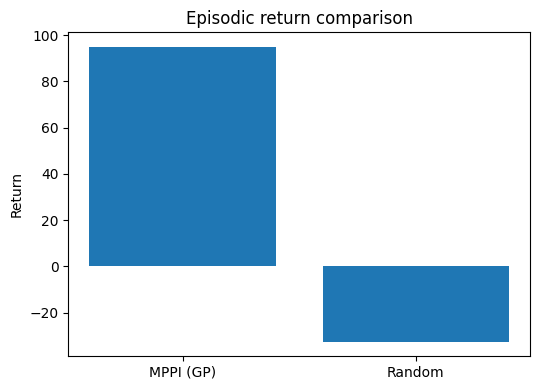

Return MPPI:  94.81
Return Random:-32.50


In [ ]:
# ---------- Part D: Evaluate & Visualize (tuned MPPI) ----------
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch

assert 'MPPI' in globals(), "Define MPPI first (Window 2)."
assert 'gp_dynamics_predict' in globals(), "Run Part B first."
assert 'GOAL_POS' in globals()

# ---- Helpers ----
def run_mppi_trajectory(H=120, K=1024, sigma=0.6, lam=50.0, rho=0.95,
                        max_steps=500, seed=0, render_mode=None, warm_left=1):
    """Run one MPPI episode and record trajectory."""
    env = gym.make("MountainCarContinuous-v0", render_mode=render_mode)
    obs, _ = env.reset(seed=seed)
    low, high = env.action_space.low[0], env.action_space.high[0]

    mppi = MPPI(low, high, H=H, K=K, sigma=sigma, lam=lam, seed=seed, rho=rho)
    # strong left shove to help discover the swing; MPPI will refine it
    mppi.U_bar[:min(warm_left, H)] = -0.95

    traj = {"pos": [], "vel": [], "act": [], "rew": []}
    total_return = 0.0
    for t in range(max_steps):
        a = mppi.plan(obs).detach().cpu().numpy()
        obs, r, terminated, truncated, _ = env.step(a)
        traj["pos"].append(obs[0]); traj["vel"].append(obs[1])
        traj["act"].append(float(a[0])); traj["rew"].append(r)
        total_return += r
        if terminated or truncated:
            break
    env.close()
    return (np.array(traj["pos"]), np.array(traj["vel"]),
            np.array(traj["act"]), np.array(traj["rew"]), float(total_return))

def run_random_trajectory(max_steps=999, seed=1, render_mode=None):
    """Random baseline."""
    env = gym.make("MountainCarContinuous-v0", render_mode=render_mode)
    obs, _ = env.reset(seed=seed)
    low, high = env.action_space.low[0], env.action_space.high[0]
    rng = np.random.default_rng(seed)

    traj = {"pos": [], "vel": [], "act": [], "rew": []}
    total_return = 0.0
    for t in range(max_steps):
        a = rng.uniform(low, high, size=(1,)).astype(np.float32)
        obs, r, terminated, truncated, _ = env.step(a)
        traj["pos"].append(obs[0]); traj["vel"].append(obs[1])
        traj["act"].append(float(a[0])); traj["rew"].append(r)
        total_return += r
        if terminated or truncated:
            break
    env.close()
    return (np.array(traj["pos"]), np.array(traj["vel"]),
            np.array(traj["act"]), np.array(traj["rew"]), float(total_return))

# ---- Run and plot ----
pos_mppi, vel_mppi, act_mppi, rew_mppi, ret_mppi = run_mppi_trajectory(
    H=120, K=1024, sigma=0.6, lam=50.0, rho=0.95, seed=0, render_mode=None
)
pos_rand, vel_rand, act_rand, rew_rand, ret_rand = run_random_trajectory(seed=0, render_mode=None)

Tm, Tr = np.arange(len(pos_mppi)), np.arange(len(pos_rand))

# (1) Position vs. time
plt.figure(figsize=(9,4))
plt.plot(Tm, pos_mppi, label="MPPI (GP)", linewidth=2)
plt.plot(Tr, pos_rand, label="Random", alpha=0.7)
plt.axhline(0.45, linestyle="--", color="k", linewidth=1, label="Goal")
plt.xlabel("Time step"); plt.ylabel("Position")
plt.title("MountainCarContinuous — Position vs. time")
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

# (2) Episodic return comparison
plt.figure(figsize=(5.5,4))
plt.bar(["MPPI (GP)", "Random"], [ret_mppi, ret_rand])
plt.ylabel("Return")
plt.title("Episodic return comparison")
plt.tight_layout()
plt.show()


plt.figure(figsize=(,4))





print(f"Return MPPI:  {ret_mppi:.2f}")
print(f"Return Random:{ret_rand:.2f}")


### How does the GP model’s accuracy affect control?
MPC/MPPI plans by simulating the learned model forward; model bias (systematic error) accumulates across the horizon and leads to wrong rollouts, poor action weighting, and degraded performance. Methods like PILCO explicitly propagate GP uncertainty to mitigate model bias, and PETS uses ensembles to quantify epistemic uncertainty during sampling-based planning—both improving robustness when the model isn’t perfect. In short: better (and uncertainty-aware) models → better plans; high bias → brittle control. 

### How many random samples 𝐾 or horizon 𝐻 are needed?
There is no fixed number—trade off computation vs. solution quality. Larger K yields lower Monte-Carlo variance for MPPI updates. Larger H enables looking further ahead but increases model-error accumulation. In practice on MountainCarContinuous, 𝐻 ≈ 15 − 25 and 𝐾 ≈ 256 − 1024
K≈256−1024 on a GPU work well.

## Exercise 3: Getting Started with MuJoCo and XML Models
***Goal:***
The goal of this exercise is to **install MuJoCo**, explore its **Python interface**, and learn the structure of **MJCF (XML) models** used to describe robots and environments.  
By the end, you should be able to:
- Run a MuJoCo simulation locally  
- Open, modify, and reload a simple XML model  
- Use Google Colab connected to your local runtime

---

MuJoCo (“Multi-Joint dynamics with Contact”) is a fast physics engine widely used in robotics and reinforcement learning.  
It uses XML (MJCF files) to describe bodies, joints, sensors, and actuators.

In this exercise, you will:
1. Install MuJoCo on your computer  
2. Install and run Jupyter Notebook or Lab  
3. Connect Colab to your local runtime  
4. Run Mujco with existent XML (car, quadrotor, mountain)
6. Create a scene with multiple falling objects

---
## Step-by-Step Instructions
### 1 Install MuJoCo: Download and install
- Visit [https://mujoco.org/download](https://mujoco.org/download)  
- Choose the installer for your OS (Windows, macOS, or Linux)

### 2 Install Jupyter

You can use either JupyterLab or Jupyter Notebook

```
pip install jupyterlab
```

Run
```
jupyter lab
```
This should open your browser at:
```
http://localhost:8888/lab
```

### 3 Configure Google Colab to Run Locally

### 4 Run a Simple MuJoCo Simulation


In [1]:
import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
import os

# XML = r"""
# <mujoco>
# 	<worldbody>
#         <light diffuse=".5 .5 .5" pos="0 0 3" dir="0 0 -1"/>
# 		<geom type="plane" size="1 1 0.1" rgba=".9 0 0 1"/>
# 		<body pos="0 0 1">
# 			<joint type="free"/>
# 			<geom type="box" size=".1 .2 .3" rgba="0 .9 0 1"/>
# 		</body>
# 	</worldbody>
# </mujoco>
# """

## Drone
XML = r"""
<mujoco model="falling_stack">
  <compiler angle="degree" coordinate="local"/>
  <option timestep="0.002" gravity="0 0 -9.81" integrator="RK4" cone="pyramidal"/>

  <default>
    <geom condim="3" friction="0.8 0.1 0.01" density="1000" margin="0.002" solref="0.003 1"/>
  </default>

  <asset>
    <material name="mat_ground" rgba="0.2 0.2 0.25 1"/>
    <material name="mat_red"    rgba="0.8 0.25 0.25 1"/>
    <material name="mat_blue"   rgba="0.25 0.45 0.85 1"/>
    <material name="mat_green"  rgba="0.25 0.8 0.4 1"/>
  </asset>

  <worldbody>
    <!-- Ground -->
    <geom name="floor" type="plane" size="5 5 0.05" pos="0 0 0" material="mat_ground"/>

    <!-- Lower cube -->
    <body name="cube1" pos="0 0 1.00">
      <freejoint/>
      <geom name="cube1_geom" type="box" size="0.1 0.1 0.1" material="mat_red"/>
    </body>

    <!-- Upper cube -->
    <body name="cube2" pos="0 0 1.30">
      <freejoint/>
      <geom name="cube2_geom" type="box" size="0.1 0.1 0.1" material="mat_blue"/>
    </body>

    <!-- Sphere on top -->
    <body name="ball" pos="0 0 1.55">
      <freejoint/>
      <geom name="ball_geom" type="sphere" size="0.1" material="mat_green"/>
    </body>

    <!-- Light & camera -->
    <light name="toplight" pos="1 1 3" dir="-1 -1 -2" diffuse="1 1 1" specular="0.1 0.1 0.1"/>
    <!-- Only one orientation specifier (xyaxes). Remove zaxis. -->
    <camera name="iso" pos="1.2 -1.2 1.2" xyaxes="1 0 0  0 1 0"/>
  </worldbody>
</mujoco>
"""

simend = 15 #simulation time


# For callback functions
button_left = False
button_middle = False
button_right = False
lastx = 0
lasty = 0

def init_controller(model,data):
    #initialize the controller here. This function is called once, in the beginning
    pass

def controller(model, data):
    #put the controller here. This function is called inside the simulation.
    pass

def keyboard(window, key, scancode, act, mods):
    if act == glfw.PRESS and key == glfw.KEY_BACKSPACE:
        mj.mj_resetData(model, data)
        mj.mj_forward(model, data)

def mouse_button(window, button, act, mods):
    # update button state
    global button_left
    global button_middle
    global button_right

    button_left = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_LEFT) == glfw.PRESS)
    button_middle = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_MIDDLE) == glfw.PRESS)
    button_right = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_RIGHT) == glfw.PRESS)

    # update mouse position
    glfw.get_cursor_pos(window)

def mouse_move(window, xpos, ypos):
    # compute mouse displacement, save
    global lastx
    global lasty
    global button_left
    global button_middle
    global button_right

    dx = xpos - lastx
    dy = ypos - lasty
    lastx = xpos
    lasty = ypos

    # no buttons down: nothing to do
    if (not button_left) and (not button_middle) and (not button_right):
        return

    # get current window size
    width, height = glfw.get_window_size(window)

    # get shift key state
    PRESS_LEFT_SHIFT = glfw.get_key(
        window, glfw.KEY_LEFT_SHIFT) == glfw.PRESS
    PRESS_RIGHT_SHIFT = glfw.get_key(
        window, glfw.KEY_RIGHT_SHIFT) == glfw.PRESS
    mod_shift = (PRESS_LEFT_SHIFT or PRESS_RIGHT_SHIFT)

    # determine action based on mouse button
    if button_right:
        if mod_shift:
            action = mj.mjtMouse.mjMOUSE_MOVE_H
        else:
            action = mj.mjtMouse.mjMOUSE_MOVE_V
    elif button_left:
        if mod_shift:
            action = mj.mjtMouse.mjMOUSE_ROTATE_H
        else:
            action = mj.mjtMouse.mjMOUSE_ROTATE_V
    else:
        action = mj.mjtMouse.mjMOUSE_ZOOM

    mj.mjv_moveCamera(model, action, dx/height,
                      dy/height, scene, cam)

def scroll(window, xoffset, yoffset):
    action = mj.mjtMouse.mjMOUSE_ZOOM
    mj.mjv_moveCamera(model, action, 0.0, -0.05 *
                      yoffset, scene, cam)

# MuJoCo data structures
model = mj.MjModel.from_xml_string(XML)  # MuJoCo model
data = mj.MjData(model)                # MuJoCo data
cam = mj.MjvCamera()                        # Abstract camera
opt = mj.MjvOption()                        # visualization options

# Init GLFW, create window, make OpenGL context current, request v-sync
glfw.init()
window = glfw.create_window(1200, 900, "Demo", None, None)
glfw.make_context_current(window)
glfw.swap_interval(1)

# initialize visualization data structures
mj.mjv_defaultCamera(cam)
mj.mjv_defaultOption(opt)
scene = mj.MjvScene(model, maxgeom=10000)
context = mj.MjrContext(model, mj.mjtFontScale.mjFONTSCALE_150.value)

# install GLFW mouse and keyboard callbacks
glfw.set_key_callback(window, keyboard)
glfw.set_cursor_pos_callback(window, mouse_move)
glfw.set_mouse_button_callback(window, mouse_button)
glfw.set_scroll_callback(window, scroll)


#initialize the controller
init_controller(model,data)

#set the controller
mj.set_mjcb_control(controller)

while not glfw.window_should_close(window):
    time_prev = data.time

    while (data.time - time_prev < 1.0/60.0):
        mj.mj_step(model, data)

    if (data.time>=simend):
        break

    # get framebuffer viewport
    viewport_width, viewport_height = glfw.get_framebuffer_size(
        window)
    viewport = mj.MjrRect(0, 0, viewport_width, viewport_height)

    # Update scene and render
    mj.mjv_updateScene(model, data, opt, None, cam,
                       mj.mjtCatBit.mjCAT_ALL.value, scene)
    mj.mjr_render(viewport, scene, context)

    # swap OpenGL buffers (blocking call due to v-sync)
    glfw.swap_buffers(window)

    # process pending GUI events, call GLFW callbacks
    glfw.poll_events()

glfw.terminate()


# Test with the following XMLs

In [ ]:
# CAR
XML = r"""
<mujoco model="simple_car_gazebo_style">
  <option gravity="0 0 -9.81" integrator="RK4" timestep="0.002"/>
  <compiler angle="radian"/>

  <visual>
    <quality shadowsize="4096"/>
    <rgba haze="0.9 0.95 1.0 0.12"/>
  </visual>

  <asset>
    <texture name="sky" type="skybox" builtin="gradient"
             rgb1="0.75 0.85 0.95" rgb2="0.95 0.95 0.98" width="1024" height="1024"/>
    <texture name="grid" type="2d" builtin="checker" width="1024" height="1024"
             rgb1="0.36 0.39 0.42" rgb2="0.40 0.43 0.46" mark="edge" markrgb="0.62 0.66 0.70"/>
    <material name="ground_mat" texture="grid" texrepeat="40 40"
              specular="0.05" shininess="0.3" reflectance="0.2" rgba="1 1 1 1"/>
    <material name="chassis_mat" rgba="0.12 0.30 0.75 1" specular="0.2" shininess="0.4"/>
    <material name="tire_mat"    rgba="0.07 0.07 0.07 1" specular="0.05" shininess="0.2"/>
  </asset>

  <default>
    <!-- No default rgba here; let materials show through -->
    <geom contype="1" conaffinity="1" friction="1.0 0.1 0.01" density="500"/>
    <joint limited="false" damping="0.1"/>
    <motor ctrlrange="-2 2"/>
  </default>

  <worldbody>
    <light name="sun_dir" directional="true" castshadow="true"
           pos="0 0 5" dir="0.2 0.3 -1" diffuse="0.9 0.9 0.9" specular="0.2 0.2 0.2" ambient="0.2 0.2 0.25"/>
    <light name="fill" directional="true" castshadow="false"
           pos="0 0 3" dir="-0.3 -0.2 -1" diffuse="0.3 0.3 0.35" specular="0 0 0" ambient="0.15 0.15 0.18"/>

    <geom name="floor" type="plane" pos="0 0 0" size="20 20 0.1" material="ground_mat"/>

    <!-- Chassis center at z=0.22 = wheel_radius(0.10)+half_chassis(0.10)+clearance(0.02) -->
    <body name="chassis" pos="0 0 0.22">
      <freejoint name="chassis_free"/>
      <geom name="chassis_box" type="box" size="0.40 0.25 0.10" material="chassis_mat"/>

      <!-- Wheel radius=0.10; centers should be at absolute z=0.10.
           Relative z offset = 0.10 - 0.22 = -0.12 (below chassis center). -->
      <!-- Cylinder axis along y: rotate +90deg about x -->
      <body name="wheel_fl" pos=" 0.35  0.22 -0.12">
        <joint name="j_fl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_fl" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_fr" pos=" 0.35 -0.22 -0.12">
        <joint name="j_fr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_fr" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_rl" pos="-0.35  0.22 -0.12">
        <joint name="j_rl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_rl" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_rr" pos="-0.35 -0.22 -0.12">
        <joint name="j_rr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_rr" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor name="m_fl" joint="j_fl" gear="120"/>
    <motor name="m_fr" joint="j_fr" gear="120"/>
    <motor name="m_rl" joint="j_rl" gear="120"/>
    <motor name="m_rr" joint="j_rr" gear="120"/>
  </actuator>
</mujoco>
"""

In [ ]:
## Drone
XML = r"""
<mujoco model="quad2d">
  <option gravity="0 0 -9.81" timestep="0.005"/>
  <worldbody>
    <body name="quad" pos="0 0 1">
      <!-- 2D DOF -->
      <joint name="x"     type="slide" axis="1 0 0" limited="false"/>
      <joint name="z"     type="slide" axis="0 0 1" limited="false"/>
      <joint name="pitch" type="hinge" axis="0 1 0" limited="false"/>

      <!-- frame -->
      <geom type="box" size="0.15 0.02 0.01" rgba="0.2 0.5 0.8 1"/>

      <!-- thruster sites (±arm) -->
      <site name="left"  pos="-0.15 0 0" size="0.01" rgba="1 0 0 1"/>
      <site name="right" pos="+0.15 0 0" size="0.01" rgba="0 1 0 1"/>

      <!-- mass/inertia (defaults are fine for demo) -->
      <inertial pos="0 0 0" mass="0.6" diaginertia="0.002 0.002 0.004"/>
    </body>

    <!-- ground plane -->
    <geom name="ground" type="plane" pos="0 0 0" size="5 5 0.1" rgba="0.8 0.8 0.8 1"/>
  </worldbody>

<actuator>
  <!-- Control u in [0, 20]; actual applied force = gainprm[0] * u along gear direction -->
  <general name="thrust_left"  site="left"
           biastype="affine" gainprm="1"
           ctrllimited="true" ctrlrange="0 20"
           gear="0 0 1  0 0 0"/>

  <general name="thrust_right" site="right"
           biastype="affine" gainprm="1"
           ctrllimited="true" ctrlrange="0 20"
           gear="0 0 1  0 0 0"/>
</actuator>


  <sensor>
    <framepos    name="pos"  objtype="body" objname="quad"/>
    <frameangvel name="omega" objtype="body" objname="quad"/>
    <framelinvel name="vlin"  objtype="body" objname="quad"/>
  </sensor>
</mujoco>
"""

In [ ]:
# Mountain

XML = r"""
<mujoco model="car_on_piecewise_curved_ramp">
  <option gravity="0 0 -9.81" integrator="RK4" timestep="0.002"/>
  <compiler angle="radian"/>

  <visual>
    <quality shadowsize="4096"/>
    <rgba haze="0.9 0.95 1.0 0.10"/>
  </visual>

  <asset>
    <texture name="sky" type="skybox" builtin="gradient"
             rgb1="0.75 0.85 0.95" rgb2="0.95 0.95 0.98" width="1024" height="1024"/>
    <texture name="grid" type="2d" builtin="checker" width="1024" height="1024"
             rgb1="0.36 0.39 0.42" rgb2="0.40 0.43 0.46" mark="edge" markrgb="0.62 0.66 0.70"/>
    <material name="ground_mat" texture="grid" texrepeat="12 2"
              specular="0.05" shininess="0.3" reflectance="0.08" rgba="1 1 1 1"/>

    <!-- Car materials -->
    <material name="paint" rgba="0.10 0.22 0.70 1" specular="0.45" shininess="0.7" reflectance="0.10"/>
    <material name="glass" rgba="0.20 0.28 0.35 0.35" specular="0.6" shininess="0.8" reflectance="0.1"/>
    <material name="tire"  rgba="0.06 0.06 0.06 1" specular="0.05" shininess="0.2"/>
    <material name="rim"   rgba="0.85 0.85 0.88 1" specular="0.6" shininess="0.8"/>
    <material name="black" rgba="0.04 0.04 0.05 1" specular="0.1" shininess="0.2"/>
  </asset>

  <default>
    <geom contype="1" conaffinity="1" friction="1.3 0.1 0.01" density="500"/>
    <joint limited="false" damping="0.1"/>
    <motor ctrlrange="-2 2"/>
  </default>

  <worldbody>
    <light name="sun" directional="true" castshadow="true"
           pos="0 0 8" dir="0.25 0.3 -1" diffuse="0.9 0.9 0.9" specular="0.2 0.2 0.2" ambient="0.2 0.2 0.25"/>
    <light name="fill" directional="true" castshadow="false"
           pos="-2 -2 4" dir="0.3 0.1 -1" diffuse="0.35 0.35 0.4" specular="0 0 0" ambient="0.15 0.15 0.18"/>

    <camera name="valley_view" mode="fixed" pos="-3.2 -1.2 1.3" euler="0.12 0.42 0.8" fovy="45"/>

    <!-- ========= Piecewise-curved ramp (sign-corrected pitches) =========
         z(x) = 0.15 x^2  ->  dz/dx = 0.30 x  ->  pitch θy = -atan(0.30 x)
         Centers at x = [-2.25, -1.75, -1.25, -0.75, -0.25, 0, 0.25, 0.75, 1.25, 1.75, 2.25]
    -->
    <geom name="seg_m2_25" type="box" size="0.25 1.0 0.02" pos="-2.25 0 0.759" euler="0  0.595 0" material="ground_mat"/>
    <geom name="seg_m1_75" type="box" size="0.25 1.0 0.02" pos="-1.75 0 0.459" euler="0  0.487 0" material="ground_mat"/>
    <geom name="seg_m1_25" type="box" size="0.25 1.0 0.02" pos="-1.25 0 0.234" euler="0  0.358 0" material="ground_mat"/>
    <geom name="seg_m0_75" type="box" size="0.25 1.0 0.02" pos="-0.75 0 0.084" euler="0  0.221 0" material="ground_mat"/>
    <geom name="seg_m0_25" type="box" size="0.25 1.0 0.02" pos="-0.25 0 0.009" euler="0  0.075 0" material="ground_mat"/>
    <geom name="seg_0"     type="box" size="0.25 1.0 0.02" pos=" 0.00 0 0.000" euler="0  0.000 0" material="ground_mat"/>
    <geom name="seg_p0_25" type="box" size="0.25 1.0 0.02" pos=" 0.25 0 0.009" euler="0 -0.075 0" material="ground_mat"/>
    <geom name="seg_p0_75" type="box" size="0.25 1.0 0.02" pos=" 0.75 0 0.084" euler="0 -0.221 0" material="ground_mat"/>
    <geom name="seg_p1_25" type="box" size="0.25 1.0 0.02" pos=" 1.25 0 0.234" euler="0 -0.358 0" material="ground_mat"/>
    <geom name="seg_p1_75" type="box" size="0.25 1.0 0.02" pos=" 1.75 0 0.459" euler="0 -0.487 0" material="ground_mat"/>
    <geom name="seg_p2_25" type="box" size="0.25 1.0 0.02" pos=" 2.25 0 0.759" euler="0 -0.595 0" material="ground_mat"/>
    <geom name="ground"    type="plane" pos="0 0 -0.02" size="10 10 0.1" material="ground_mat"/>

        <!-- Translucent narrow walls to keep the car aligned -->
    <geom name="left_wall"
          type="box"
          size="2.6 0.02 0.5"
          pos="0  0.2 0.45"
          rgba="0.6 0.8 1.0 0.15"
          material="ground_mat"/>

    <geom name="right_wall"
          type="box"
          size="2.6 0.02 0.5"
          pos="0 -0.2 0.45"
          rgba="0.6 0.8 1.0 0.15"
          material="ground_mat"/>



    <!-- ===== Car (same spec as before, slightly smaller) ===== -->
    <body name="chassis" pos="-1.5 0 0.70">
      <freejoint/>
      <geom type="box"       size="0.24 0.15 0.06" material="paint"/>
      <geom type="ellipsoid" size="0.15 0.12 0.06" pos="0.03 0 0.07" material="glass"/>
      <geom type="box"       size="0.05 0.15 0.02" pos="-0.30 0 -0.03" material="black"/>

      <!-- Wheels: radius=0.05, axle along local y -->
      <body name="wheel_fl" pos=" 0.20  0.13 -0.085">
        <joint name="j_fl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_fr" pos=" 0.20 -0.13 -0.085">
        <joint name="j_fr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_rl" pos="-0.19  0.13 -0.085">
        <joint name="j_rl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_rr" pos="-0.19 -0.13 -0.085">
        <joint name="j_rr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor joint="j_fl" gear="120"/>
    <motor joint="j_fr" gear="120"/>
    <motor joint="j_rl" gear="120"/>
    <motor joint="j_rr" gear="120"/>
  </actuator>
</mujoco>


"""

## Create a Scene with Falling Objects

Now let’s create a small **physics scene** to understand how MuJoCo handles **contacts and collisions**.

You’ll build an XML with **two cubes and one sphere**, stacked vertically so that they fall and collide naturally under gravity.

Add a screenshot in a cell of the notebook.

![Screenshot from 2025-10-28 11-50-40.png](<attachment:Screenshot from 2025-10-28 11-50-40.png>)
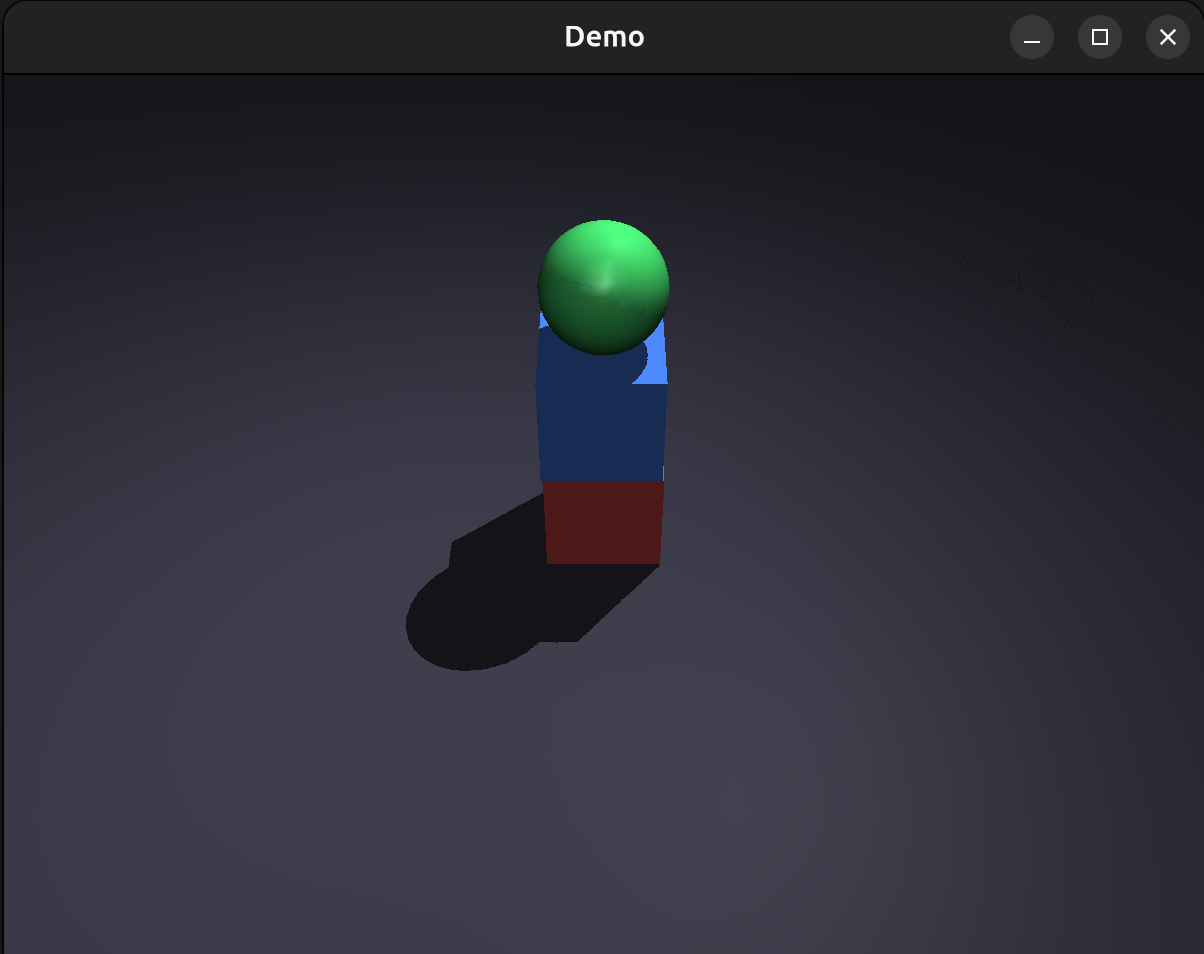